<a href="https://colab.research.google.com/github/Yashvishe13/Deep-Learning/blob/main/Anime_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [2]:
# ! kaggle datasets download splcher/animefacedataset

In [3]:
# ! unzip animefacedataset

In [4]:
# importing libraries
import tensorflow as tf
from keras.layers import BatchNormalization, LeakyReLU, Input, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys, os
from glob import glob

In [5]:
data = glob('images/*.jp*g')

img = cv2.imread(data[0])
res = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
res.shape

(64, 64, 3)

In [6]:
# Load the data
i = 0
dataset = np.ndarray(shape=(63565, 64, 64, 3),
                     dtype=np.float32)
images = glob('images/*.jp*g')
for photo in images:
  img = cv2.imread(images[i])
  x = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
  x = (x - 127.5) / 127.5
  dataset[i] = x
  i += 1
  if i % 10000 == 0:
      print("%d images to array" % i)
print("All images to array!")

10000 images to array
20000 images to array
30000 images to array
40000 images to array
50000 images to array
60000 images to array
All images to array!


In [7]:
dataset.shape

(63565, 64, 64, 3)

In [8]:
# Flatten the data
N, H, W, C = dataset.shape
D = H * W * C
dataset = dataset.flatten().reshape(dataset.shape[0], D)
print("dataset.shape: ", dataset.shape)

dataset.shape:  (63565, 12288)


In [9]:
# Dimensionality of latent space
latent_dim = 128

In [10]:
# Generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [11]:
# discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [12]:
# Compile both model for training

# Build and compile discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# Build generator
generator = build_generator(latent_dim)

# create input to represent noise sample
z = Input(shape=(latent_dim, ))
img = generator(z)

# Only Generator should be trained
discriminator.trainable = False

# label fake output as real
fake_pred = discriminator(img)

# combined model
combined_model = Model(z, fake_pred)

# compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [13]:
# Train the GAN

# Training configs
batch_size = 128
epochs = 10000
sample_period = 100

# create batch labels to use for train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the losses
d_losses = []
g_losses = []

# Create folder to store images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [14]:
# A function to generate a grid of random samples from the generator and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(5, 5)
  idx = 0
  for i in range(5):
    for j in range(5):
      axs[i,j].imshow(imgs[idx].reshape(H, W, C), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [15]:
# Main training loop
for epoch in range(epochs):
  # Train discriminator
  # selecting random batch of real images
  idx = np.random.randint(0, dataset.shape[0], batch_size)
  real_imgs = dataset[idx]

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # Train discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)

epoch: 1/10000, d_loss: 0.92,       d_acc: 0.10, g_loss: 0.51
epoch: 101/10000, d_loss: 0.49,       d_acc: 0.64, g_loss: 0.82
epoch: 201/10000, d_loss: 0.61,       d_acc: 0.55, g_loss: 0.68
epoch: 301/10000, d_loss: 0.60,       d_acc: 0.59, g_loss: 0.75
epoch: 401/10000, d_loss: 0.66,       d_acc: 0.57, g_loss: 0.74
epoch: 501/10000, d_loss: 0.72,       d_acc: 0.47, g_loss: 0.81
epoch: 601/10000, d_loss: 0.77,       d_acc: 0.36, g_loss: 0.79
epoch: 701/10000, d_loss: 0.80,       d_acc: 0.21, g_loss: 0.83
epoch: 801/10000, d_loss: 0.78,       d_acc: 0.27, g_loss: 0.88
epoch: 901/10000, d_loss: 0.78,       d_acc: 0.27, g_loss: 0.79
epoch: 1001/10000, d_loss: 0.80,       d_acc: 0.28, g_loss: 0.84
epoch: 1101/10000, d_loss: 0.80,       d_acc: 0.25, g_loss: 0.79
epoch: 1201/10000, d_loss: 0.79,       d_acc: 0.25, g_loss: 0.88
epoch: 1301/10000, d_loss: 0.80,       d_acc: 0.23, g_loss: 0.80
epoch: 1401/10000, d_loss: 0.79,       d_acc: 0.26, g_loss: 0.86
epoch: 1501/10000, d_loss: 0.80,     

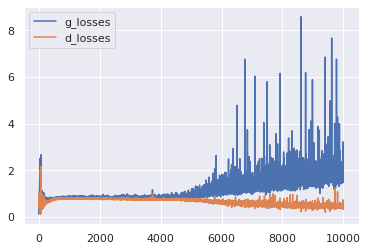

In [16]:
# Plotting loss
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [17]:
!ls gan_images

0.png	    2100.png  3500.png	4900.png  6200.png  7600.png  9000.png
100000.png  2200.png  3600.png	5000.png  6300.png  7700.png  900.png
1000.png    2300.png  3700.png	500.png   6400.png  7800.png  9100.png
100.png     2400.png  3800.png	5100.png  6500.png  7900.png  9200.png
1100.png    2500.png  3900.png	5200.png  6600.png  8000.png  9300.png
1200.png    2600.png  4000.png	5300.png  6700.png  800.png   9400.png
1300.png    2700.png  400.png	5400.png  6800.png  8100.png  9500.png
1400.png    2800.png  4100.png	5500.png  6900.png  8200.png  9600.png
1500.png    2900.png  4200.png	5600.png  7000.png  8300.png  9700.png
1600.png    3000.png  4300.png	5700.png  700.png   8400.png  9800.png
1700.png    300.png   4400.png	5800.png  7100.png  8500.png  9900.png
1800.png    3100.png  4500.png	5900.png  7200.png  8600.png
1900.png    3200.png  4600.png	6000.png  7300.png  8700.png
2000.png    3300.png  4700.png	600.png   7400.png  8800.png
200.png     3400.png  4800.png	6100.png  7500.png  890

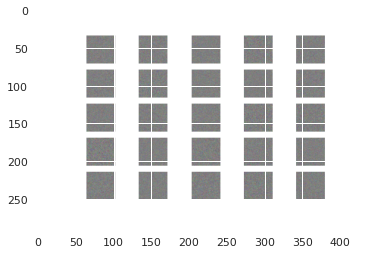

In [18]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

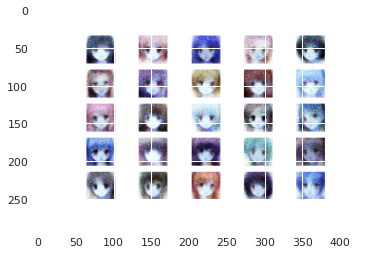

In [22]:
a = imread('gan_images/1000.png')
plt.imshow(a)

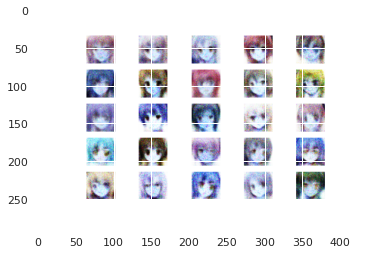

In [23]:
a = imread('gan_images/5000.png')
plt.imshow(a)

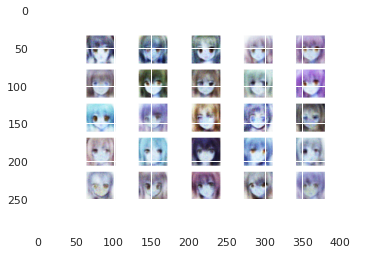

In [24]:
a = imread('gan_images/9900.png')
plt.imshow(a)

In [20]:
# Generating new image
sample_images(100000)

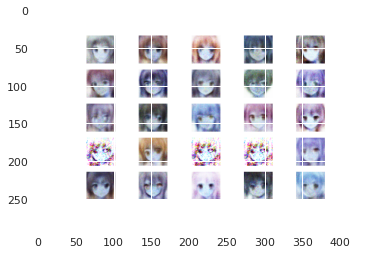

In [21]:
a = imread('gan_images/100000.png')
plt.imshow(a)